Best Parameters Found by GridSearchCV:
{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1-macro (train CV splits): 0.670
Train Accuracy (best_rf): 0.789
Test Accuracy (best_rf):  0.685

Classification Report (Test, best_rf):
              precision    recall  f1-score   support

   Non-Toxic       0.67      0.82      0.74       108
       Toxic       0.72      0.52      0.60        92

    accuracy                           0.69       200
   macro avg       0.69      0.67      0.67       200
weighted avg       0.69      0.69      0.68       200



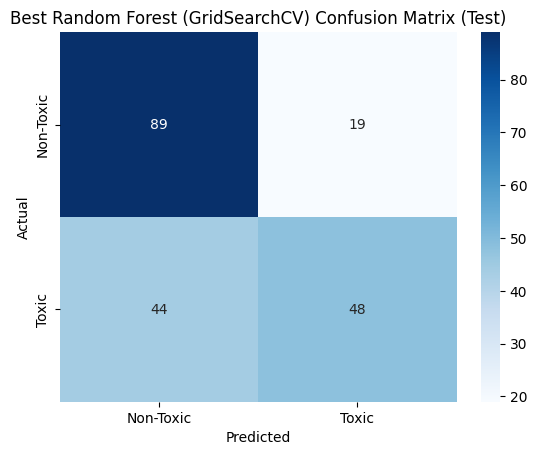

Most important words for Best Random Forest (by Gini importance):
fucking: 0.0454
thank: 0.0444
shit: 0.0425
fuck: 0.0421
ass: 0.0362
run: 0.0355
video: 0.0312
thug: 0.0306
shoot: 0.0271
peggy: 0.0245


In [4]:
import pandas as pd
import re

# Load and clean data
df = pd.read_csv('../data/youtoxic_english_1000.csv')
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+", "", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()
df['CleanText'] = df['Text'].apply(clean_text)
X = df['CleanText']
y = df['IsToxic'].astype(int)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    max_features= 500
)
X_tfidf = vectorizer.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Parameter grid to search
param_grid = {
    'n_estimators': [25, 50, 75,100],
    'max_depth': [2,3,4,5,6],
    'min_samples_split': [10,20,30,40],
    'min_samples_leaf': [5,10,20],
    'max_features': ['sqrt', 0.3, 0.5]
}

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

grid_rf = GridSearchCV(
    rf_base,
    param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Best Parameters Found by GridSearchCV:")
print(grid_rf.best_params_)
print(f"Best CV F1-macro (train CV splits): {grid_rf.best_score_:.3f}")

# Evaluate best model on test data
best_rf = grid_rf.best_estimator_
y_pred_test = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Train Accuracy (best_rf): {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Test Accuracy (best_rf):  {accuracy_score(y_test, y_pred_test):.3f}\n")
print("Classification Report (Test, best_rf):")
print(classification_report(y_test, y_pred_test, target_names=['Non-Toxic', 'Toxic']))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Best Random Forest (GridSearchCV) Confusion Matrix (Test)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

import numpy as np

importances = best_rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()
indices = np.argsort(importances)[-10:][::-1]
print("Most important words for Best Random Forest (by Gini importance):")
for idx in indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")